In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from scipy.optimize import minimize

In [6]:
tsla_forecast = pd.read_csv('/content/lstm_forecast_results.csv', index_col='Date', parse_dates=True)
bnd_data = pd.read_csv('/content/BND_historical_data.csv', index_col='Date', parse_dates=True)
spy_data = pd.read_csv('/content/SPY_historical_data.csv', index_col='Date', parse_dates=True)


In [7]:
# Forecast BND using ARIMA
def forecast_arima(series, steps=30):
    model = ARIMA(series, order=(5,1,0))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    return forecast

bnd_forecast = forecast_arima(bnd_data['Close'])

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

In [10]:
# Forecast SPY using LSTM
def prepare_lstm_data(data, look_back=10):
    X, y = [], []
    for i in range(len(data)-look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    return np.array(X), np.array(y)

look_back = 30
spy_series = spy_data['Close'].values.reshape(-1,1)
X_train, y_train = prepare_lstm_data(spy_series, look_back)

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=1)

spy_forecast = []
input_seq = spy_series[-look_back:]
for _ in range(30):
    input_seq_reshaped = input_seq.reshape(1, look_back, 1)
    pred = model.predict(input_seq_reshaped)[0]
    spy_forecast.append(pred)
    input_seq = np.append(input_seq[1:], pred).reshape(-1, 1)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2505/2505 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - loss: 36145.6953
Epoch 2/20
2505/2505 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - loss: 425.4061
Epoch 3/20
2505/2505 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - loss: 251.9333
Epoch 4/20
2505/2505 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 223.1999
Epoch 5/20
2505/2505 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 660.1365
Epoch 6/20
2505/2505 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - loss: 207.8917
Epoch 7/20
2505/2505 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - loss: 222.5039
Epoch 8/20
2505/2505 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 204.2465
Epoch 9/20
2505/2505 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 132.6445
Epoch 10/20
2505/2505 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - loss: 163.5696
Epoch 11/20
2505/2505 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 141.9371
Epoch 12/20
2505/2505 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 151.5795
Epoch 13/20
2505/2505 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 107.0616
Epoch 14/20
2505/2505 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step

In [16]:
spy_forecast = np.array(spy_forecast).flatten()  # Ensure it's a 1D numeric array

In [17]:
# Combine Forecasts
forecast_dates = pd.date_range(start=tsla_forecast.index[-1], periods=30, freq='D')
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'TSLA': tsla_forecast['Forecast'].values[-30:],
    'BND': bnd_forecast.values,
    'SPY': spy_forecast
}).set_index('Date')

In [18]:
# Compute Daily Returns
returns = forecast_df.pct_change().dropna()


In [19]:
# Portfolio Optimization
def portfolio_stats(weights, returns):
    portfolio_return = np.sum(weights * returns.mean()) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility
    return portfolio_return, portfolio_volatility, sharpe_ratio

def neg_sharpe(weights, returns):
    return -portfolio_stats(weights, returns)[2]

In [20]:
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = [(0, 1)] * 3
initial_weights = [1/3, 1/3, 1/3]
opt_result = minimize(neg_sharpe, initial_weights, args=(returns,), method='SLSQP', bounds=bounds, constraints=constraints)

optimized_weights = opt_result.x


In [21]:
# Risk Analysis
portfolio_return, portfolio_volatility, sharpe_ratio = portfolio_stats(optimized_weights, returns)
VaR_95 = np.percentile(returns['TSLA'], 5)

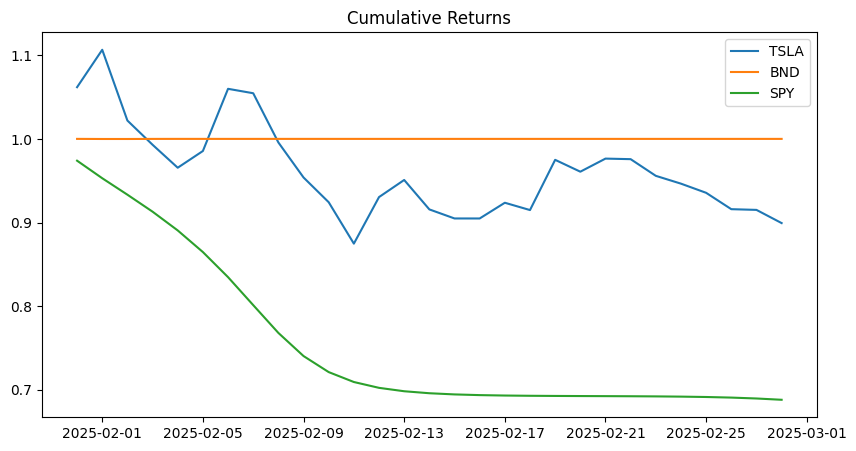

In [22]:
# Visualization
plt.figure(figsize=(10,5))
plt.plot((1 + returns).cumprod(), label=['TSLA', 'BND', 'SPY'])
plt.legend()
plt.title('Cumulative Returns')
plt.show()

In [23]:
# Summary
print(f'Optimized Portfolio Weights: TSLA: {optimized_weights[0]:.2f}, BND: {optimized_weights[1]:.2f}, SPY: {optimized_weights[2]:.2f}')
print(f'Expected Annual Return: {portfolio_return:.2f}')
print(f'Portfolio Volatility: {portfolio_volatility:.2f}')
print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
print(f'TSLA Value at Risk (95% confidence): {VaR_95:.4f}')

Optimized Portfolio Weights: TSLA: 1.00, BND: 0.00, SPY: 0.00
Expected Annual Return: -0.74
Portfolio Volatility: 0.60
Sharpe Ratio: -1.24
TSLA Value at Risk (95% confidence): -0.0549


In [25]:
# Combine Forecasts
forecast_dates = pd.date_range(start=pd.to_datetime('today'), periods=30, freq='D')  # Adjust according to your needs
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'BND': bnd_forecast.values,
    'SPY': spy_forecast
}).set_index('Date')

# Save to CSV
forecast_df.to_csv('/content/combined_forecast_results.csv')

print('Saved combined forecast results to /content/combined_forecast_results.csv')

Saved combined forecast results to /content/combined_forecast_results.csv
